* This notebook can be run with this environment: **gdal_only.yml**
* Installing some common packages to this environment breaks it (keep gdal_only separate / try not to update)
* The commands printed here could be run directly in the command line - put in this jupyter notebook using "os.system" just for convenience

# Set up Workspace

In [1]:
import os
import time
import gdal
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
trial_number=3

In [3]:
geotiff_folder = "/eos9/czarakas/Code/forest_fragmentation/distance_to_edge/"
geotiff_fname_original = geotiff_folder+"distancefromforestedge_pantropics"+".tif"

# Look at original geotiff

Dimensions: (11232, 62113)
Drawing geotiff takes: 13.73 seconds


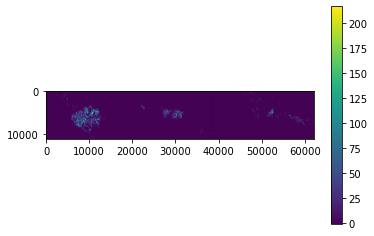

In [4]:
tic = time.time()
ds = gdal.Open(geotiff_fname_original)
darray = ds.ReadAsArray()
print('Dimensions: '+str(np.shape(darray)))
plt.imshow(darray)
plt.colorbar()
toc = time.time()
print('Drawing geotiff takes: '+str(np.round(toc-tic,2))+' seconds')

# Reformat Distance to Edge Dataset
Converts GEOTIFF to reprojected NETCDF

Documentation for gdalwarp is [here](https://gdal.org/programs/gdalwarp.html); "-s_srs" sets source spatial reference, and "t_srs" sets target spatial reference

#### Reproject distance to edge dataset (.tif -> .tif)

In [5]:
tic = time.time()
geotiff_fname_reproj = geotiff_folder+"distancefromforestedge_pantropics"+"_reprojected"+str(trial_number)+"a.tif"
os_string = "gdalwarp -t_srs EPSG:4326 " +geotiff_fname_original + " " +geotiff_fname_reproj
os.system(os_string)
print(os_string)
toc = time.time()
print('---------------')
print('Reprojecting geotiff takes: '+str(np.round(toc-tic,2))+' seconds')

gdalwarp -t_srs EPSG:4326 /eos9/czarakas/Code/forest_fragmentation/distance_to_edge/distancefromforestedge_pantropics.tif /eos9/czarakas/Code/forest_fragmentation/distance_to_edge/distancefromforestedge_pantropics_reprojected3a.tif
---------------
Reprojecting geotiff takes: 32.93 seconds


#### Set no data values (currently no data=-1) to null (.tif -> .tif)

In [6]:
tic = time.time()
geotiff_fname_reproj2 = geotiff_folder+"distancefromforestedge_pantropics"+"_reprojected"+str(trial_number)+"b.tif"
os_string = "gdal_translate -a_nodata none "+geotiff_fname_reproj+" "+geotiff_fname_reproj2
os.system(os_string)
print(os_string)
toc = time.time()
print('---------------')
print('Rewriting null values takes: '+str(np.round(toc-tic,2))+' seconds')

gdal_translate -a_nodata none /eos9/czarakas/Code/forest_fragmentation/distance_to_edge/distancefromforestedge_pantropics_reprojected3a.tif /eos9/czarakas/Code/forest_fragmentation/distance_to_edge/distancefromforestedge_pantropics_reprojected3b.tif
---------------
Rewriting null values takes: 10.52 seconds


#### Convert distance to edge tiff dataset to netcdf (.tif -> .nc)

In [7]:
tic = time.time()
nc_fname_reproj2 = geotiff_folder+"distancefromforestedge_pantropics"+"_reprojected"+str(trial_number)+"b.nc"
os_string = "gdal_translate -of netcdf -co FORMAT=NC4  "+geotiff_fname_reproj2+" "+nc_fname_reproj2
os.system(os_string)
print(os_string)
toc = time.time()
print('---------------')
print('Converting to netcdf takes: '+str(np.round(toc-tic,2))+' seconds')

gdal_translate -of netcdf -co FORMAT=NC4  /eos9/czarakas/Code/forest_fragmentation/distance_to_edge/distancefromforestedge_pantropics_reprojected3b.tif /eos9/czarakas/Code/forest_fragmentation/distance_to_edge/distancefromforestedge_pantropics_reprojected3b.nc
---------------
Converting to netcdf takes: 12.41 seconds


# Confirm that it works to plot new netcdf file w/xarray

Get info on reprojected netcdf

In [8]:
print(gdal.Info(nc_fname_reproj2))

Driver: netCDF/Network Common Data Format
Files: /eos9/czarakas/Code/forest_fragmentation/distance_to_edge/distancefromforestedge_pantropics_reprojected3b.nc
Size is 62269, 10334
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-111.998890676276289,23.399999998390339)
Pixel Size = (0.004528714558388,-0.004528714558388)
Metadata:
  Band1#grid_mapping=crs
  Band1#long_name=GDAL Band Number 1
  Band1#_FillValue=9.969209968386869e+36
  crs#GeoTransform=-111.9988906762763 0.00

In [14]:
ds = xr.open_dataset(nc_fname_reproj2)
ds

<xarray.Dataset>
Dimensions:  (lat: 10334, lon: 62269)
Coordinates:
  * lat      (lat) float64 -23.4 -23.39 -23.39 -23.38 ... 23.38 23.39 23.39 23.4
  * lon      (lon) float64 -112.0 -112.0 -112.0 -112.0 ... 170.0 170.0 170.0
Data variables:
    crs      |S1 ...
    Band1    (lat, lon) float64 ...
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 3.1.0, released 2020/05/03
    history:             Thu Aug 27 12:49:40 2020: GDAL CreateCopy( /eos9/cza...